IMPORT LIBRARIES

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage
import os
import tqdm
import glob
import tensorflow

from tqdm import tqdm
#from sklearn.utils import shuffle
#from sklearn.model_selection import train_test_split

#from skimage.io import imread, imshow
#from skimage.transform import resize

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPool2D, Conv2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.densenet import DenseNet169
from tensorflow.keras.preprocessing.image import load_img, img_to_array

IMPORT / VIEWING / PREPROCESSING DATASET

DATA AUGMENTATION

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range=30,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   validation_split = 0.2)

valid_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split = 0.2)

test_datagen  = ImageDataGenerator(rescale = 1./255)

In [ ]:
train_dataset  = train_datagen.flow_from_directory(directory = '/content/drive/MyDrive/Colab_Notebooks/Alzheimer_Prediction/DataSet',
                                                   target_size = (128,128),
                                                   class_mode = 'categorical',
                                                   subset = 'training',
                                                   batch_size = 128)

Found 5121 images belonging to 4 classes.


In [ ]:
valid_dataset  = valid_datagen.flow_from_directory(directory = '/content/drive/MyDrive/Colab_Notebooks/Alzheimer_Prediction/DataSet',
                                                   target_size = (128,128),
                                                   class_mode = 'categorical',
                                                   subset = 'validation',
                                                   batch_size = 128)


Found 1279 images belonging to 4 classes.


100%|██████████| 5/5 [00:58<00:00, 11.76s/it]


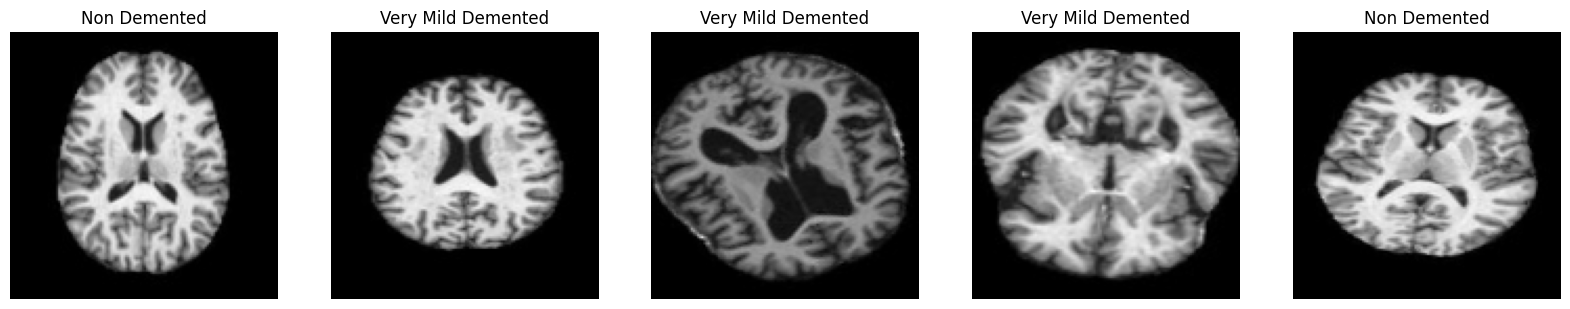

In [ ]:
fig, ax = plt.subplots(nrows = 1, ncols = 5, figsize=(20,20))

for i in tqdm(range(0,5)):
    rand1 = np.random.randint(len(train_dataset))
    rand2 = np.random.randint(100)
    ax[i].imshow(train_dataset[rand1][0][rand2])
    ax[i].axis('off')
    a = train_dataset[rand1][1][rand2]
    if a[0] == 1:
        ax[i].set_title('Mild Demented')
    elif a[1] == 1:
        ax[i].set_title('Moderate Demented')
    elif a[2] == 1:
        ax[i].set_title('Non Demented')
    elif a[3] == 1:
        ax[i].set_title('Very Mild Demented')

MODEL BUILDING

In [ ]:
# Model Initialization

base_model = DenseNet169(input_shape=(128,128,3),
                         include_top=False,
                         weights="imagenet")

51877672/51877672 [==============================] - 0s 0us/step


In [ ]:
# Freezing Layers

for layer in base_model.layers:
    layer.trainable=False

In [ ]:
# Building Model

model=Sequential()
model.add(base_model)
model.add(Dropout(0.5))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(2048,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1024,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(4,activation='softmax'))

In [ ]:
# Summary

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet169 (Functional)    (None, 4, 4, 1664)        12642880  
                                                                 
 dropout (Dropout)           (None, 4, 4, 1664)        0         
                                                                 
 flatten (Flatten)           (None, 26624)             0         
                                                                 
 batch_normalization (Batch  (None, 26624)             106496    
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 2048)              54528000  
                                                                 
 batch_normalization_1 (Bat  (None, 2048)              8192      
 chNormalization)                                       

In [ ]:
# Model Compile

OPT    = tensorflow.keras.optimizers.Adam(lr=0.001)

model.compile(loss='categorical_crossentropy',
              metrics=[tensorflow.keras.metrics.AUC(name = 'auc')],
              optimizer=OPT)

In [83]:
# Defining Callbacks

filepath = './best_weights.hdf5'

earlystopping = EarlyStopping(monitor = 'val_auc',
                              mode = 'max' ,
                              patience = 15,
                              verbose = 1)

checkpoint    = ModelCheckpoint(filepath,
                                monitor = 'val_auc',
                                mode='max',
                                save_best_only=True,
                                verbose = 1)


callback_list = [earlystopping, checkpoint]

In [84]:
model_history=model.fit(train_dataset,
                        validation_data=valid_dataset,
                        epochs = 500,
                        callbacks = callback_list,
                        verbose = 1)

Epoch 1/500
41/41 [==============================] - ETA: 0s - loss: 0.6507 - auc: 0.9202
Epoch 1: val_auc improved from -inf to 0.72851, saving model to ./best_weights.hdf5
41/41 [==============================] - 39s 947ms/step - loss: 0.6507 - auc: 0.9202 - val_loss: 1.6694 - val_auc: 0.7285
Epoch 2/500
41/41 [==============================] - ETA: 0s - loss: 0.6488 - auc: 0.9208
Epoch 2: val_auc did not improve from 0.72851
41/41 [==============================] - 35s 855ms/step - loss: 0.6488 - auc: 0.9208 - val_loss: 1.8515 - val_auc: 0.6901
Epoch 3/500
41/41 [==============================] - ETA: 0s - loss: 0.6260 - auc: 0.9263
Epoch 3: val_auc improved from 0.72851 to 0.77924, saving model to ./best_weights.hdf5
41/41 [==============================] - 41s 997ms/step - loss: 0.6260 - auc: 0.9263 - val_loss: 1.4986 - val_auc: 0.7792
Epoch 4/500
41/41 [==============================] - ETA: 0s - loss: 0.6323 - auc: 0.9249
Epoch 4: val_auc did not improve from 0.77924
41/41 [====

MODEL EVALUATION

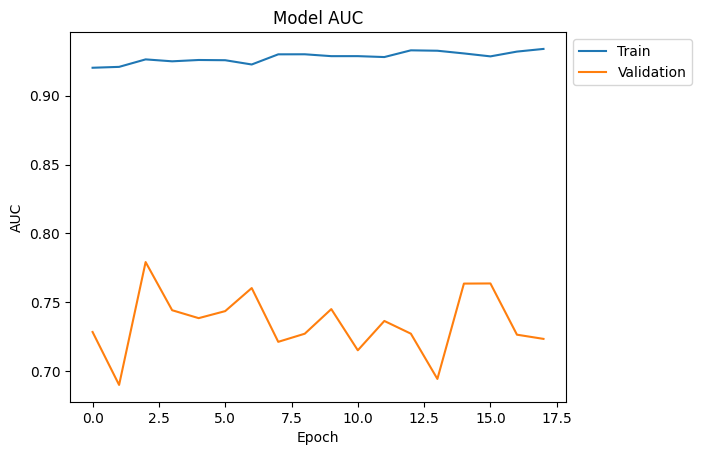

In [85]:
# Summarize history for Aucc

plt.plot(model_history.history['auc'])
plt.plot(model_history.history['val_auc'])
plt.title('Model AUC')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

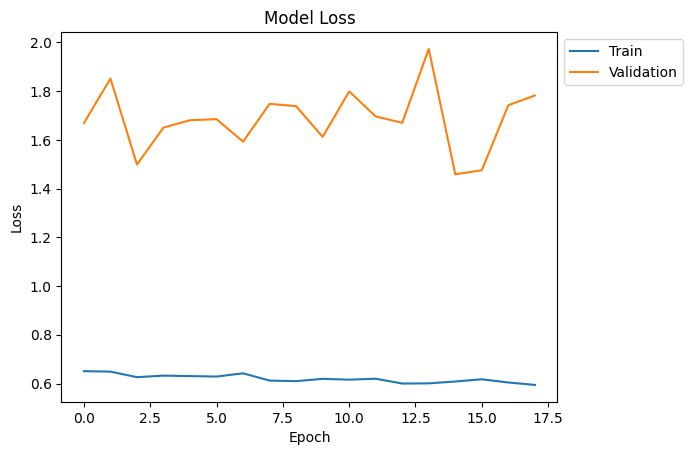

In [86]:
# Summarize history for loss

plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

In [87]:
#Evaluating Loss and AUC

model.evaluate(train_dataset)

41/41 [==============================] - 34s 816ms/step - loss: 0.4630 - auc: 0.9613


[0.4629635810852051, 0.9613435864448547]

Model Save

In [88]:
model.save('/content/drive/MyDrive/Colab_Notebooks/Alzheimer_Prediction/densenet.h5')